# SSD300 Evaluation for Deepfake Detection

This is a brief tutorial that explains how to compute the average precisions for any trained SSD model using the `Evaluator` class. The `Evaluator` computes the average precisions according to the Pascal VOC pre-2010 or post-2010 detection evaluation algorithms.

The `Evaluator` works for any SSD model and any dataset that is compatible with the `DataGenerator`.

In [1]:
# Loading in the necessary Python modules
from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam
from scipy.misc import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from data_generator.object_detection_2d_data_generator import DataGenerator
from eval_utils.average_precision_evaluator import Evaluator

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set a few configuration parameters.
img_height = 300
img_width = 300
n_classes = 2
model_mode = 'training'

## 1. Load a trained SSD model

We set `model_mode` to 'training' above, so the evaluator expects that I load a model that was built in 'training' mode. If I'm loading a model that was built in 'inference' mode, change the `model_mode` parameter accordingly.

In [3]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = './model_output/ssd300_epoch-10_loss-1.8947_val_loss-4.8366.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})















Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.




## 2. Create a data generator for the evaluation dataset

Instantiate a `DataGenerator` that will serve the evaluation dataset during the prediction phase.

In [4]:
dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

# TODO: Set the paths to the images and test dataset here.

# The directory that contains the images
images_dir = './images_dir/py-keras-job-dir/all_videos/'

# CSV file of the ground truth test dataset annotation labels
test_labels_filename = './images_dir/py-keras-job-dir/all_videos/labels_test.csv'

dataset.parse_csv(images_dir=images_dir,
                  labels_filename=test_labels_filename,
                  input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                  include_classes='all')

## 3. Run the evaluation

Now that we have instantiated a model and a data generator to serve the dataset, we can set up the evaluator and run the evaluation.

The evaluator is quite flexible: It can compute the average precisions according to the Pascal VOC pre-2010 algorithm, which samples 11 equidistant points of the precision-recall curves, or according to the Pascal VOC post-2010 algorithm, which integrates numerically over the entire precision-recall curves instead of sampling a few individual points. I can also change the number of sampled recall points or the required IoU overlap for a prediction to be considered a true positive, among other things. Check out the `Evaluator`'s documentation for details on all the arguments.

In its default settings, the evaluator's algorithm is identical to the official Pascal VOC pre-2010 Matlab detection evaluation algorithm.

The evaluator roughly performs the following steps: It runs predictions over the entire given dataset, then it matches these predictions to the ground truth boxes, then it computes the precision-recall curves for each class, then it samples 11 equidistant points from these precision-recall curves to compute the average precision for each class, and finally it computes the mean average precision over all classes.

Note: It takes approximately 2 hours for predictions to be run over the entire test dataset.

In [5]:
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=dataset,
                      model_mode=model_mode)

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=8,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 45920

Matching predictions to ground truth, class 2/2.: 100%|██████████| 396955/396955 [00:27<00:00, 14286.27it/s]
Computing precisions and recalls, class 1/2
Computing precisions and recalls, class 2/2
Computing average precision, class 1/2
Computing average precision, class 2/2


## 4. Visualize the results

In [6]:
classes = ['background',
           'real', 'fake']

for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

real          AP    0.239
fake          AP    0.629

              mAP   0.434


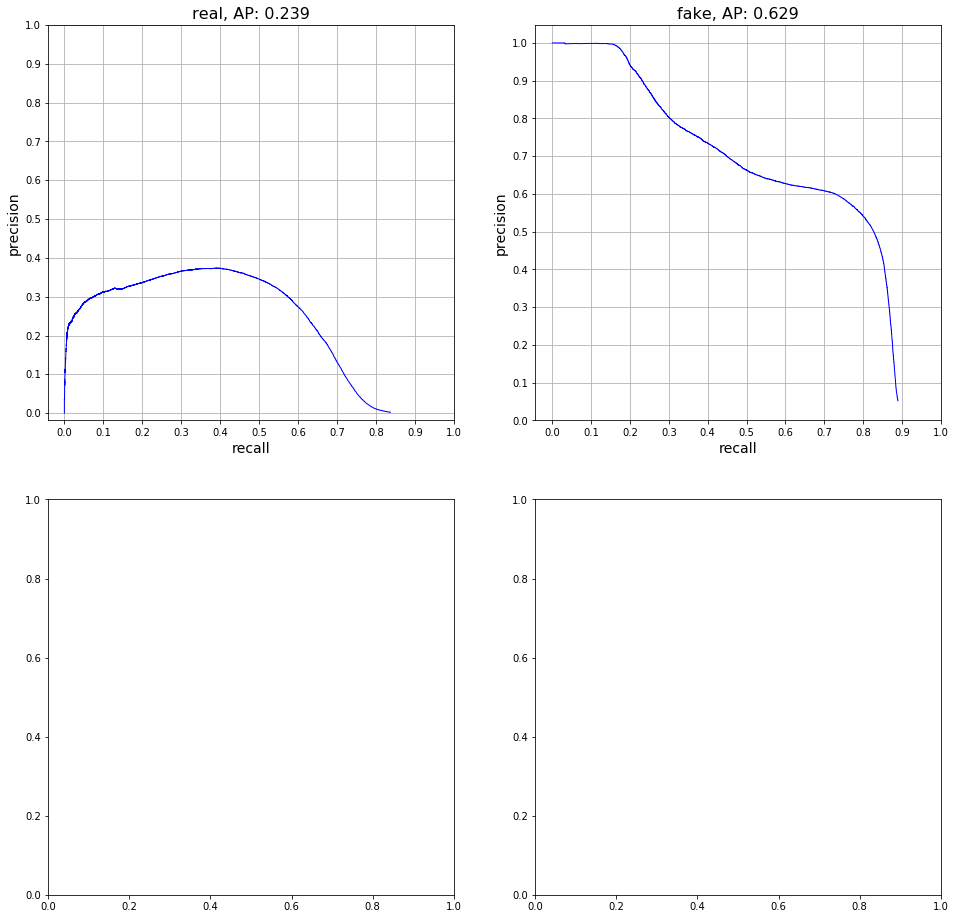

In [7]:
m = max((n_classes + 1) // 2, 2)
n = 2

# TODO: Set the name of the output image for the model being tested.
fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > n_classes: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=14)
        cells[i, j].set_ylabel('precision', fontsize=14)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(classes[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)
        plt.savefig('./model_output/ssd300_epoch-10_eval_pre-2010.png')

## 5. Advanced use

`Evaluator` objects maintain copies of all relevant intermediate results like predictions, precisions and recalls, etc., so in case I want to experiment with different parameters, e.g. different IoU overlaps, there is no need to compute the predictions all over again every time I make a change to a parameter. Instead, I can only update the computation from the point that is affected onwards.

The evaluator's `__call__()` method is just a convenience wrapper that executes its other methods in the correct order. I could just call any of these other methods individually as shown below (but I have to make sure to call them in the correct order).

Note that the example below uses the same evaluator object as above. Say I wanted to compute the Pascal VOC post-2010 'integrate' version of the average precisions instead of the pre-2010 version computed above. The evaluator object still has an internal copy of all the predictions, and since computing the predictions makes up the vast majority of the overall computation time and since the predictions aren't affected by changing the average precision computation mode, we skip computing the predictions again and instead only compute the steps that come after the prediction phase of the evaluation. We could even skip the matching part, since it isn't affected by changing the average precision mode either. In fact, we would only have to call `compute_average_precisions()` and `compute_mean_average_precision()` again, but for the sake of illustration we'll re-do the other computations, too.

In [8]:
evaluator.get_num_gt_per_class(ignore_neutral_boxes=True,
                               verbose=False,
                               ret=False)

evaluator.match_predictions(ignore_neutral_boxes=True,
                            matching_iou_threshold=0.5,
                            border_pixels='include',
                            sorting_algorithm='quicksort',
                            verbose=True,
                            ret=False)

precisions, recalls = evaluator.compute_precision_recall(verbose=True, ret=True)

average_precisions = evaluator.compute_average_precisions(mode='integrate',
                                                          num_recall_points=11,
                                                          verbose=True,
                                                          ret=True)

mean_average_precision = evaluator.compute_mean_average_precision(ret=True)

Matching predictions to ground truth, class 2/2.: 100%|██████████| 396955/396955 [00:28<00:00, 13963.23it/s]
Computing precisions and recalls, class 1/2
Computing precisions and recalls, class 2/2
Computing average precision, class 1/2
Computing average precision, class 2/2


In [9]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

real          AP    0.244
fake          AP    0.652

              mAP   0.448


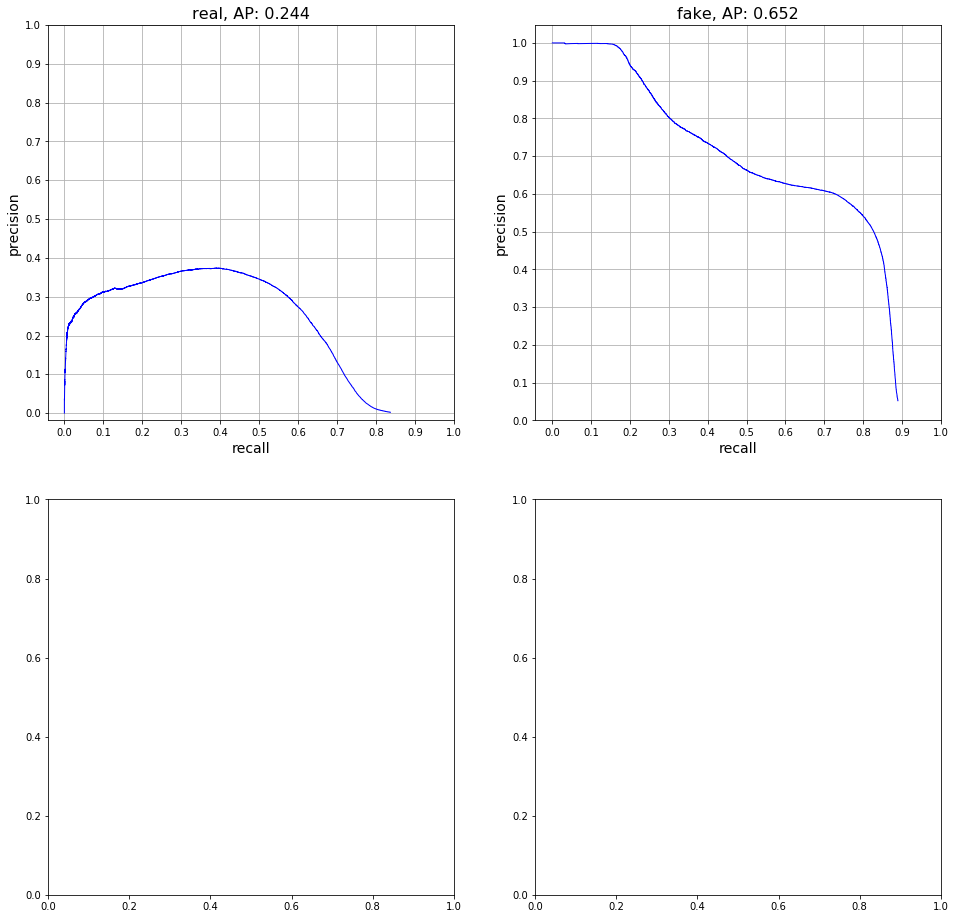

In [10]:
m = max((n_classes + 1) // 2, 2)
n = 2

# TODO: Set the name of the output image for the model being tested.
fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > n_classes: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=14)
        cells[i, j].set_ylabel('precision', fontsize=14)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(classes[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)
        plt.savefig('./model_output/ssd300_epoch-10_eval_post-2010.png')